In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, \
                            plot_confusion_matrix, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [4]:
from feature_engineering.get_data import read_dataset
from feature_engineering.preprocessing import preprocessing

# Configure GCS

In [5]:
labels_columns = ['project_short_name','clinical_stage', 'clinical_T', 'clinical_N',
                 'clinical_M','pathologic_stage', 'pathologic_T',
                 'pathologic_N','pathologic_M']
betas, labels, cpg_sites, index = read_dataset('input/', label_names = labels_columns,
                                               project_filter='TCGA-BRCA',
                                               gcs_prefix='pivot_data_v5/', nb_partition=110)

C:\Users\adrien.galamez\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\google\auth\_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/



Loaded dataset. Shape = (1131, 5000)


In [6]:
raw_data = np.concatenate((betas, labels), axis=1)
raw_labels = np.concatenate((cpg_sites,labels_columns), axis=0)
df = pd.DataFrame(raw_data, columns=raw_labels, index=index)

In [7]:
df.head()

,cg23563234,cg23317501,cg23326689,cg15873301,cg18722841,cg25612480,cg06906435,cg04598121,cg14011639,cg21624282,...,cg19166347,project_short_name,clinical_stage,clinical_T,clinical_N,clinical_M,pathologic_stage,pathologic_T,pathologic_N,pathologic_M
TCGA-GM-A2DF-01A,0.389755,0.43161,0.668303,0.151552,0.489455,0.55746,0.668383,0.531357,0.26178,0.601343,...,0.202918,TCGA-BRCA,NaN,NaN,NaN,NaN,Stage IIA,T1c,N1a,M0
TCGA-BH-A0DH-01A,0.596614,0.746191,0.467631,0.885628,0.742717,0.650429,0.150489,0.685145,0.327248,0.444933,...,0.255389,TCGA-BRCA,NaN,NaN,NaN,NaN,Stage IIB,T2,N1a,M0
TCGA-E2-A154-01A,0.559902,0.494677,0.807704,0.75958,0.566608,0.94857,0.343665,0.748465,0.43187,0.164488,...,0.0493032,TCGA-BRCA,NaN,NaN,NaN,NaN,Stage I,T1c,N0,M0
TCGA-B6-A0IM-01A,0.768202,0.210738,0.624885,0.144513,0.0701166,0.894517,0.0802163,0.586182,0.420428,0.544592,...,0.0734059,TCGA-BRCA,NaN,NaN,NaN,NaN,Stage IIB,T3,N0 (i-),M0
TCGA-E9-A24A-01A,0.650221,0.138314,0.501011,0.524418,0.0985161,0.602108,0.171529,0.4009,0.16603,0.556069,...,0.0982603,TCGA-BRCA,NaN,NaN,NaN,NaN,Stage IIA,T1c,N1,M0


# Pre-processing

## Label formatting

In [17]:
map_sub_labels_to_classes = {
 'Stage I': 1,
 'Stage IA': 1,
 'Stage IB': 1,
 'Stage II': 2,
 'Stage IIA': 2,
 'Stage IIB': 2,
 'Stage III': 3,
 'Stage IIIA': 3,
 'Stage IIIB': 3,
 'Stage IIIC': 3,
 'Stage IV': 4,
 'Stage X': 5,
 np.nan: np.nan
}

In [59]:
sub_labels = labels[:, 5]
sub_labels = [map_sub_labels_to_classes[elt] for elt in sub_labels]

## Re-balance dataset

In [61]:
unique, count = np.unique(sub_labels, return_counts = True)
count_values = {key: c for (key, c) in zip(unique, count)}
nb_value_majority_class = max(count)
print(count_values)

{1.0: 183, 2.0: 651, 3.0: 254, 4.0: 21, 5.0: 13, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1}


In [64]:
resampling_strategy = {
    1: int(0.5 * nb_value_majority_class),
    2: nb_value_majority_class,
    3: int(0.5 * nb_value_majority_class),
    4: int(0.5 * nb_value_majority_class),
    5: int(0.5 * nb_value_majority_class)
}
print(resampling_strategy)

{1: 325, 2: 651, 3: 325, 4: 325, 5: 325}


## Train Test Split

In [65]:
X_train, X_test, y_train, y_test, sub_labels, cpg_sites = preprocessing(betas, sub_labels, cpg_sites, smote=True,
                                                                       sampling_strategy=resampling_strategy)

=== Drop Columns and Rows ===
Dropping 9 because of missing labels
New Shape = (1122, 5000)
Dropping columns which have more than 10% of values missing
0 columns will be dropped.
betas: New shape is (1122, 5000)
cpg_sites: New shape is (5000,)

Dropping rows which have more than 10% of values missing
We will drop 1 rows
betas: New shape is (1121, 5000)
labels: New shape is (1121,)

=== Fill remaining NAs ===
Filling remaining NA values using a KNNImputer
2048 NA were filled, i.e. approximately 1.83 per rows

=== Train / Test Split ===
Splitting dataset into train and test
Train = 70 %
Test = 30 %

=== Standardize dataset ===
The average of column mean on train is 0.00
The average of column mean on test is 0.02

=== Balance dataset ===
After rebalancing the training set, the ratio positive / negative observation is {1: 325, 2: 651, 3: 325, 4: 325, 5: 325}


C:\Users\adrien.galamez\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\imblearn\utils\_validation.py:253: UserWarning:

After over-sampling, the number of samples (651) in class 2 will be larger than the number of samples in the majority class (class #2.0 -> 452)

C:\Users\adrien.galamez\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

C:\Users\adrien.galamez\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

C:\Users\adrien.galamez\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in versio

1167 rows were added in the training data


We have the following labels:
    - 0 means that the methylation are taken from normal samples
    - Strictly positive number are taken from cancerous samples and indicate the cancer stage:
      - 1 means Stage 1
      - 2 means Stage 2
      - 3 means Stage 3
      - 4 means Stage 4

In [69]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_train))

# Overlay both histograms
fig.update_layout(bargroupgap=0.2,
                  title="Histogram of labels to predict",
                  xaxis_title="Cancer Stage",
                  yaxis_title="Count of observations")

fig.show()

# Modeling

Sample section using a Decision Tree classifier. The goal is to output a `predictions` vector using the test set (i.e. `X_test` and `y_test`) to be able to process the following evaluation section. This vectors should hold the probabilities that a patient will belong to the positive class (i.e. cancerous, part of the BRCA Study).

## Hyperparameter Tuning

We will optimize two hyperparameter on decision trees:
 1. alpha defined by
   $$ R_{\alpha}(T) = R(T) + \alpha |T|$$
   with $|T|$ number of terminal nodes in the tree and $R$ the misclassification rate of terminal nodes. We will test $\alpha \in [0, 0.01, 0.05, 0.1, 0.2]$.
 2. Maximum number of features considered for a single split. We will test (all, `sqrt`, `log2`)

In [70]:
alpha_range = [0, 1e-4, 1e-3, 0.01]
feature_range = [None, 0.1, 0.4, 0.7]

In [71]:
kf = StratifiedKFold(n_splits=4)
parameters = {'ccp_alpha': alpha_range, 'max_features': feature_range}
decision_tree = DecisionTreeClassifier()
clf = GridSearchCV(decision_tree, parameters, cv=kf, verbose=10, scoring='f1_weighted',
                  n_jobs=4)

In [72]:
clf.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   28.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   56.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:  2.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=4,
        

In [73]:
clf.cv_results_

{'mean_fit_time': array([17.04954123,  2.17901254,  6.73074812, 12.02693909, 17.26652795,
         2.14583522,  7.33610648, 11.8637957 , 16.91806364,  2.13879132,
         7.14222443, 12.12560582, 17.24824017,  2.05872935,  7.5304054 ,
        12.88460737]),
 'std_fit_time': array([1.02159743, 0.11434973, 0.69536068, 0.70623193, 1.04997602,
        0.20281318, 0.39474388, 1.12424782, 0.85834452, 0.07259495,
        0.27545233, 0.46986607, 0.8722353 , 0.05256398, 0.21181298,
        0.5549828 ]),
 'mean_score_time': array([0.0334695 , 0.03147691, 0.02888215, 0.02945685, 0.03190416,
        0.02788359, 0.02936041, 0.02879357, 0.0331986 , 0.03069735,
        0.02884591, 0.02862138, 0.0315975 , 0.03123248, 0.02677655,
        0.03546488]),
 'std_score_time': array([0.00421454, 0.00122743, 0.00391987, 0.00291318, 0.00122718,
        0.00307589, 0.00354637, 0.00313522, 0.0011286 , 0.0019337 ,
        0.00191302, 0.0028222 , 0.00173478, 0.00097078, 0.00342171,
        0.0085741 ]),
 'param_cc

In [74]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [75]:
best_alpha = 1e-3
best_max_features = None

In [76]:
best_params = clf.best_estimator_.get_params()
best_alpha = best_params['ccp_alpha']
best_max_features = best_params['max_features']

In [77]:
print(f"We found that alpha = {best_alpha} and max features = {best_max_features} are " \
      "the best parameter according to CV.")

We found that alpha = 0.001 and max features = 0.7 are the best parameter according to CV.


## Training

In [78]:
clf = DecisionTreeClassifier(ccp_alpha=best_alpha, max_features=best_max_features)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Explore Model

### Feature importance

In [79]:
sorted(zip(range(0, len(cpg_sites)), cpg_sites, clf.feature_importances_), key=lambda x: x[2], reverse=1)

[(1691, 'cg02844545', 0.09173471460379672),
 (2854, 'cg19615059', 0.08587754121048698),
 (3043, 'cg19896198', 0.05204720113915535),
 (3494, 'cg16831889', 0.035164788569865955),
 (987, 'cg25020204', 0.03411330333040365),
 (4835, 'cg17133183', 0.029799934561720125),
 (3121, 'cg21258987', 0.028570364516297908),
 (3156, 'cg10014293', 0.024707056095830335),
 (2866, 'cg27227156', 0.014399085348883022),
 (1193, 'cg05352668', 0.014098079399609845),
 (4147, 'cg08465774', 0.013959742120893426),
 (1943, 'cg25870420', 0.012611110774683625),
 (2684, 'cg19005210', 0.012003012448665501),
 (4763, 'cg06872381', 0.011308794299506127),
 (1191, 'cg02867079', 0.011260304309411823),
 (1629, 'cg04345475', 0.011062108122615669),
 (598, 'cg24103438', 0.01090221222435813),
 (2916, 'cg24110063', 0.01074675102324109),
 (993, 'cg18488855', 0.009735109995034855),
 (2823, 'cg10613381', 0.009698123042452657),
 (374, 'cg04336572', 0.009456430964335358),
 (2915, 'cg02719634', 0.009421895249512929),
 (3203, 'cg12638745'

### Analyze Tree

In [80]:
estimator = clf
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 271 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 1691] <= 0.8045575022697449 else to node 214.
	node=1 test node: go to node 2 if X[:, 3121] <= 0.003722307737916708 else to node 109.
		node=2 test node: go to node 3 if X[:, 987] <= 0.5713458955287933 else to node 88.
			node=3 test node: go to node 4 if X[:, 4835] <= 1.3751456141471863 else to node 79.
				node=4 test node: go to node 5 if X[:, 4147] <= 0.41351571679115295 else to node 42.
					node=5 test node: go to node 6 if X[:, 598] <= 0.27640825510025024 else to node 33.
						node=6 test node: go to node 7 if X[:, 993] <= 0.8704300820827484 else to node 30.
							node=7 test node: go to node 8 if X[:, 3273] <= 1.2473145723342896 else to node 29.
								node=8 test node: go to node 9 if X[:, 4038] <= 1.1567766070365906 else to node 28.
									node=9 test node: go to node 10 if X[:, 4587] <= -1.400564193725586 else to node 15.
										node=10 test node: go t

## Testing

In [85]:
predictions = clf.predict_proba(X_test)

In [86]:
predictions

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.97333333, 0.02666667, 0.        , 0.        ],
       ...,
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ]])

# Evaluate Model

## Metrics

Let's compute the raw accuracy score as a rough proxy for model performance. In a multi-class classification problem, the accuracy is defined as the number of observation classified in the correct class divided by the total number of observations.

First, on the training set

In [87]:
# Training
training_predicted_labels = clf.predict(X_train)
acc_training = accuracy_score(training_predicted_labels, y_train)
print(f"The train accuracy is {acc_training:.2f}")

The train accuracy is 0.98


Then, on the test set

In [88]:
# Testing
testing_predicted_labels = clf.predict(X_test)
acc_testing = accuracy_score(testing_predicted_labels, y_test)
print(f"The test accuracy is {acc_testing:.2f}")

The test accuracy is 0.39


## Confusion Matrix

**All the metrics below are influenced by the chosen threshold**

In [89]:
threshold = 0.5

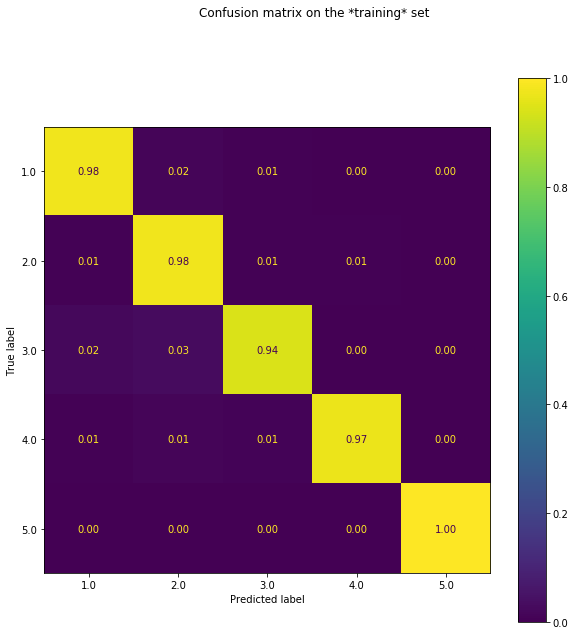

In [90]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
f.suptitle("Confusion matrix on the *training* set")
plot_confusion_matrix(clf, X_train, y_train, ax=ax, values_format='.2f', normalize='true');

In [91]:
m = classification_report(y_train, clf.predict(X_train))
print(m)

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       325
         2.0       0.97      0.98      0.97       651
         3.0       0.97      0.94      0.96       325
         4.0       0.98      0.97      0.98       325
         5.0       1.00      1.00      1.00       325

    accuracy                           0.98      1951
   macro avg       0.98      0.97      0.98      1951
weighted avg       0.98      0.98      0.98      1951



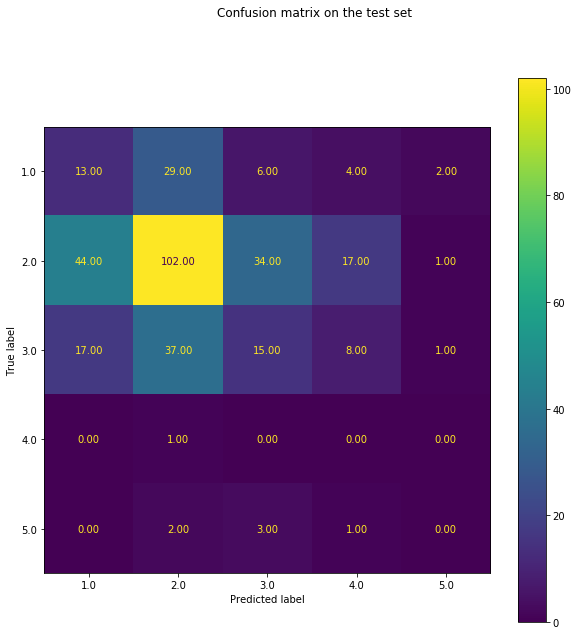

In [94]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
f.suptitle("Confusion matrix on the test set")
plot_confusion_matrix(clf, X_test, y_test, ax=ax, values_format='.2f', normalize=None);

In [95]:
m = classification_report(y_test, clf.predict(X_test))
print(m)

              precision    recall  f1-score   support

         1.0       0.18      0.24      0.20        54
         2.0       0.60      0.52      0.55       198
         3.0       0.26      0.19      0.22        78
         4.0       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         6

    accuracy                           0.39       337
   macro avg       0.21      0.19      0.20       337
weighted avg       0.44      0.39      0.41       337



## F1 Score

In a multi-class problem, let's use the weighted f1 score. The weighted f1 score is the average of the 5 f1 score (one per class) weighted by the number of observation by class.

In [96]:
print(f"The F1 scode on the training set is {f1_score(y_train, clf.predict(X_train), average='weighted'):.3f}")

The F1 scode on the training set is 0.975


In [97]:
score = f1_score(y_test, clf.predict(X_test), average='weighted')

In [98]:
print(f"The F1 score on the test set is {score:.3f}")

The F1 score on the test set is 0.408
